# CLs method
The hep_spt package also provides tools to work with the CLs method. This method is oftenly used in High Energy Physics to reject models, preventing the exclusion when there is not enough statistical power. The rejection is determined comparing an alternative model, with repect to the null model. In this document you can see an example of how to work with the different classes and functions here present.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, chi2, norm

## The CLs test statistics
Here we are going to create four different models (related two by two). The first two will follow a poissonian distribution, while the other two will be gaussians. Note that we can only work with only one type o functions, i.e. either both models follow a discrete or a continuous function. We will then plot the distributions of the null and alternative hypotheses, together with their associated test-statistics.

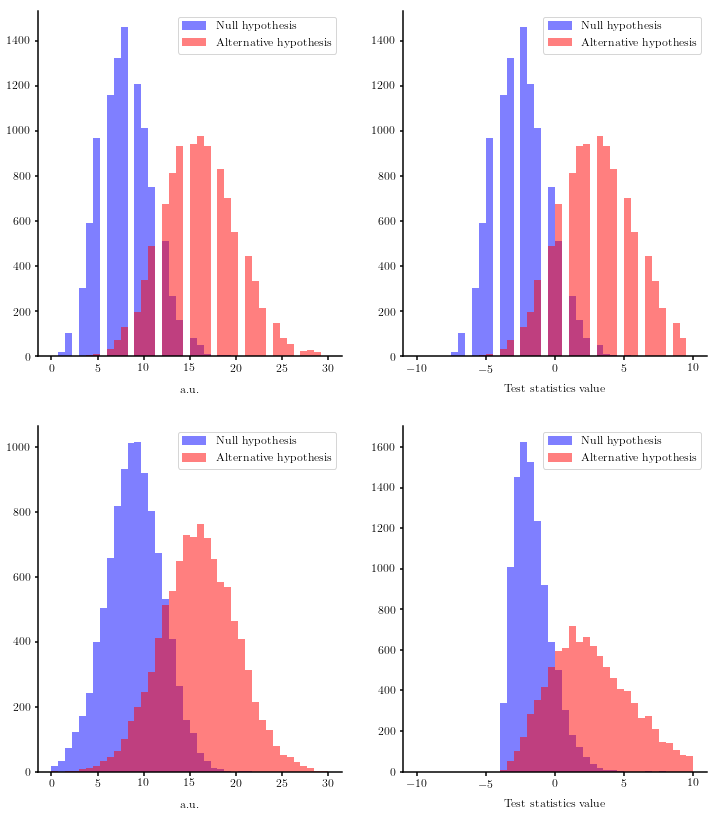

In [2]:
import hep_spt
hep_spt.set_style('multiplot')

fig, (axs0, axs1) = plt.subplots(2, 2)

for i, (ax0, ax1) in enumerate((axs0, axs1)):

    if i == 0:
        alt  = hep_spt.cls_hypo(poisson, 16)
        null = hep_spt.cls_hypo(poisson, 8)
    else:
        alt  = hep_spt.cls_hypo(norm, 16, 4)
        null = hep_spt.cls_hypo(norm, 9, 3)

    a_smp = hep_spt.rv_random_sample(alt.func)
    n_smp = hep_spt.rv_random_sample(null.func)

    cls_mgr = hep_spt.cls_ts(alt, null)

    # Plot the line referring to the percentiles
    ax0.hist(n_smp, 40, range=(0, 30), color='blue', histtype='stepfilled', alpha=0.5, label='Null hypothesis')
    ax0.hist(a_smp, 40, range=(0, 30), color='red', histtype='stepfilled', alpha=0.5, label='Alternative hypothesis')
    ax0.set_xlabel('a.u.')
    ax0.legend()

    # Plot the test-statistics for the two hypotheses
    ax1.hist(cls_mgr.test_stat(n_smp), 40, range=(-10, 10), color='blue', alpha=0.5, label='Null hypothesis')
    ax1.hist(cls_mgr.test_stat(a_smp), 40, range=(-10, 10), color='red', alpha=0.5, label='Alternative hypothesis')
    ax1.set_xlabel('Test statistics value')
    ax1.legend()

## Running a CLs scan
Oftenly, we have a model that depends on a certain parameter, which we use to determine the rejection. In this case we will assume that we are looking for a signal on a sample, which can only be explained by an alternative model (so our expectation is full-background). Our parameter for the scan will be the effect of our new model (the number of entries over the background). The value of this effect might vary in the alternative model, thus we can use the CLs method to reduce the allowed value-space for it. We will consider that we have three bins, which might be related, for example, to different independent samples with tighter cuts in each of them.

Limits:
- 90% CL: 2.3161
- 95% CL: 2.7964


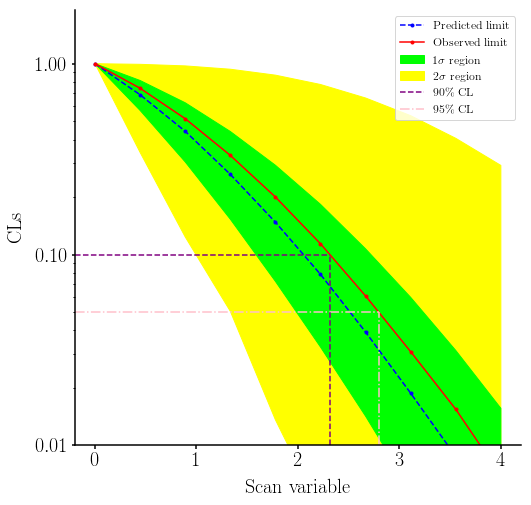

In [3]:
from collections import OrderedDict as odict
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import interp1d
import matplotlib.lines as lines
hep_spt.set_style('singleplot')

# Define the background, the effect of the alternative model and the observation
bkg = np.array([25., 16., 9.])
eff = np.array([3., 2., 1.])
obs = np.array([29., 13., 10.])

dct = odict([('x', np.linspace(0., 4., 10))])
for v in ('y', 'y1sl', 'y1sr', 'y2sl', 'y2sr', 'yobs'):
    dct[v] = []

# 1 and 2 sigma intervals
sig1 = chi2(1).cdf(1)
sig2 = chi2(1).cdf(4)

null = hep_spt.cls_hypo(norm, bkg, np.sqrt(bkg))
for i in dct['x']:
    a = i*eff + bkg
    alt  = hep_spt.cls_hypo(norm, a, np.sqrt(a))

    cls_mgr = hep_spt.cls_ts(alt, null)

    # This way we calculate all the values at once, using the same sample
    # for the test-statistics for each hypothesis
    values = cls_mgr.evaluate(
        np.array([
            null.median(),
            null.percentil(1. - sig1),
            null.percentil(sig1),
            null.percentil(1. - sig2),
            null.percentil(sig2),
            obs
        ]),
        size = 1000000)

    # First item in "dct" is "x"
    for dv, v in zip(list(dct.values())[1:], values.CLs):
        dv.append(v)

# Plot the predicted and observed CLs lines, together with the 1 and 2 sigma regions
r2s_area = plt.fill_between(dct['x'], dct['y2sl'], dct['y2sr'], color='yellow')
r1s_area = plt.fill_between(dct['x'], dct['y1sl'], dct['y1sr'], color='lime')
(pre_line,) = plt.plot(dct['x'], dct['y'], color='blue', ls='--')
(obs_line,) = plt.plot(dct['x'], dct['yobs'], color='red')

# Add the 90% and 95% CL lines
xmin, _ = plt.gca().get_xbound()

x90 = interp1d(dct['yobs'], dct['x'], kind='cubic')(0.10)
x95 = interp1d(dct['yobs'], dct['x'], kind='cubic')(0.05)

line_90 = plt.gca().add_line(lines.Line2D((xmin, x90), (0.10, 0.10), color='purple', ls='--', ms=0))
line_95 = plt.gca().add_line(lines.Line2D((xmin, x95), (0.05, 0.05), color='pink', ls='-.', ms=0))

plt.gca().add_line(lines.Line2D((x90, x90), (1e-2, 0.10), color='purple', ls='--', ms=0))
plt.gca().add_line(lines.Line2D((x95, x95), (1e-2, 0.05), color='pink', ls='-.', ms=0))

# Change the scale settings
plt.gca().set_yscale('log', nonposy='clip')
plt.gca().set_ylim(1e-2, 1.9)
plt.gca().set_ylabel('CLs')
plt.gca().set_xlabel('Scan variable')
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.legend(*zip(
    (pre_line, 'Predicted limit'),
    (obs_line, 'Observed limit'),
    (r1s_area, '$1\sigma$ region'),
    (r2s_area, '$2\sigma$ region'),
    (line_90 , '90\% CL'),
    (line_95 , '95\% CL')
))

print('Limits:\n- 90% CL: {:.4f}\n- 95% CL: {:.4f}'.format(x90, x95))